# Predicting House Prices

Moving to a new area? Want to sell or buy an house? Not sure about the right price? Machine learning can be of help!
We are going to try some very simple regression models, asses their quality against some metrics and predict some house prices.

For this exercise we are going to use [Apache Spark](https://spark.apache.org/) version 2.0 and its ML library. For a general overview of Apache Spark check this [Wikipedia link](https://en.wikipedia.org/wiki/Apache_Spark). Don't forget to check [Apache Spark ML documentation](http://spark.apache.org/docs/latest/ml-guide.html) for an overview of its Machine Learning capabilites!

We are going to use the House Sales in King Country, USA available from [Kaggle website](https://www.kaggle.com/harlfoxem/housesalesprediction). You need to sign-in and download the csv file to an appropriate location in order.

In [1]:
import sys
import os

from pyspark.sql.types import *
import pyspark.sql.functions as func

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Bucketizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
import pyspark
from pyspark.sql import SQLContext

if ('sc' not in locals() or 'sc' not in globals()):
    os.environ['PYSPARK_PYTHON'] = '/usr/bin/python2'
    sc = pyspark.SparkContext('local[*]')

sqlContext = SQLContext(sc)

## Dataset exploration

Apache Spark can load data from many different datasources including CSV files. For this exercise we are gong to specify the CSV file schema as it will come handy throughout this sample.

In [15]:
kc_house_schema = StructType([\
                              StructField('id', LongType(),True),\
                              StructField('date', DateType(),True),
                              StructField('price', FloatType(),True),\
                              StructField('bedrooms',IntegerType(),True),\
                              StructField('bathrooms',FloatType(),True),\
                              StructField('sqft_living',IntegerType(),True),\
                              StructField('sqft_lot',IntegerType(),True),\
                              StructField('floors',DoubleType(),True),\
                              StructField('waterfront',IntegerType(),True),\
                              StructField('view',IntegerType(),True),\
                              StructField('condition',IntegerType(),True),\
                              StructField('grade',IntegerType(),True),\
                              StructField('sqft_above',IntegerType(),True),\
                              StructField('sqft_basement',IntegerType(),True),\
                              StructField('yr_built',IntegerType(),True),\
                              StructField('yr_renovated',IntegerType(),True),\
                              StructField('zipcode',IntegerType(),True),\
                              StructField('lat',DoubleType(),True),\
                              StructField('long',DoubleType(),True),\
                              StructField('sqft_living15',IntegerType(),True),\
                              StructField('sqft_lot15',IntegerType(),True)\
                             ])

NameError: name 'spark' is not defined

In [17]:
file_name = 'kc_house_data.csv'

kc_house_data = sqlContext.read.csv(
                    os.path.join(file_name),
                    header=True, 
                    inferSchema=False, 
                    schema=kc_house_schema,
                    dateFormat='yyyyMMdd\'T\'HHmmss')
kc_house_data.cache()

DataFrame[id: bigint, date: date, price: float, bedrooms: int, bathrooms: float, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

**Note:** Don't forget to ```cache``` frequently used DataFrames to improve speed and performache.

In [18]:
kc_house_data.columns

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

Above the list of the columns available in this dataset. We will ask Apache Spark to briefly describe some of them in order to get a general understandig of their contents. When exploring a dataset it is quite common to investigate the correlation between the different variables and the variable we are trying to predict.

In [5]:
kc_house_data.describe('price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot').show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|             21613|            21613|             21613|             21613|             21613|
|   mean| 540088.1417665294| 3.37084162309721|2.1147573219821405|2079.8997362698374|15106.967565816869|
| stddev|367127.19648270035|0.930061831147451| 0.770163157217741| 918.4408970468096| 41420.51151513551|
|    min|           75000.0|                0|               0.0|               290|               520|
|    max|         7700000.0|               33|               8.0|             13540|           1651359|
+-------+------------------+-----------------+------------------+------------------+------------------+



In [6]:
kc_house_data.describe('floors', 'waterfront', 'view', 'grade', 'sqft_above').show()

+-------+------------------+--------------------+-------------------+------------------+------------------+
|summary|            floors|          waterfront|               view|             grade|        sqft_above|
+-------+------------------+--------------------+-------------------+------------------+------------------+
|  count|             21613|               21613|              21613|             21613|             21613|
|   mean|1.4943089807060566|0.007541757275713691|0.23430342849211122| 7.656873178179799|1788.3906907879516|
| stddev|0.5399888951423489| 0.08651719772788748| 0.7663175692736114|1.1754587569743344| 828.0909776519175|
|    min|               1.0|                   0|                  0|                 1|               290|
|    max|               3.5|                   1|                  4|                13|              9410|
+-------+------------------+--------------------+-------------------+------------------+------------------+



In [7]:
kc_house_data.describe('sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long').show()

+-------+------------------+------------------+------------------+-------------------+-------------------+
|summary|     sqft_basement|          yr_built|      yr_renovated|                lat|               long|
+-------+------------------+------------------+------------------+-------------------+-------------------+
|  count|             21613|             21613|             21613|              21613|              21613|
|   mean| 291.5090454818859|1971.0051357978994| 84.40225790033776|  47.56005251931704|-122.21389640494083|
| stddev|442.57504267746685|29.373410802386243|401.67924001917504|0.13856371024192368|0.14082834238139288|
|    min|                 0|              1900|                 0|            47.1559|           -122.519|
|    max|              4820|              2015|              2015|            47.7776|           -121.315|
+-------+------------------+------------------+------------------+-------------------+-------------------+



In [8]:
kc_house_data.describe('sqft_living15', 'sqft_lot15', 'condition').show()

+-------+-----------------+------------------+------------------+
|summary|    sqft_living15|        sqft_lot15|         condition|
+-------+-----------------+------------------+------------------+
|  count|            21613|             21613|             21613|
|   mean|1986.552491556008|12768.455651691113|3.4094295100171195|
| stddev|685.3913042527788|27304.179631338524|0.6507430463662044|
|    min|              399|               651|                 1|
|    max|             6210|            871200|                 5|
+-------+-----------------+------------------+------------------+



/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


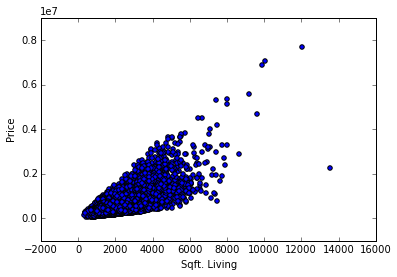

In [9]:
plt.scatter(kc_house_data.select('sqft_living').collect(),kc_house_data.select('price').collect())
plt.xlabel('Sqft. Living')
plt.ylabel('Price')
plt.show()

**Note:** The dataset is clean a ready to be used. This is not common in real life scenarios! Make sure to prepare you data before training you models

In [10]:
price_stats_map = kc_house_data.describe('price').rdd.collectAsMap()
min_price = float(price_stats_map['min'])
max_price = float(price_stats_map['max'])

num_buckets = 50 

bucket_size = (max_price - min_price) / num_buckets
splits = [float(min_price + i * bucket_size) for i in range(num_buckets+1)]

bucketizer = Bucketizer(splits=splits, inputCol="price", outputCol="bucket")

buckeizerData = kc_house_data.selectExpr('cast(price as double) price')

bucketedPrice = bucketizer.transform(buckeizerData)\
                          .groupBy('bucket')\
                          .count()\
                          .sort('bucket')

In [11]:
buckets = bucketedPrice.select('bucket').rdd.map(lambda x: x.bucket).collect()
count = bucketedPrice.select('count').rdd.map(lambda x: x['count']).collect()

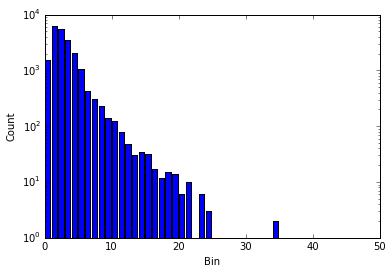

In [12]:
plt.bar(buckets,count, log=True)
plt.xlabel('Bin')
plt.ylabel('Count')
plt.show()

## Build a simple Regression model based on the 'sqft_living' only

Lets create our first Regression model to predict the house *price* based on a single feature, the *sqft_living* of the house.

First we proceed to prepare a training and test sets, let not forget to cache them to speed the performaces.  

In [13]:
train, test = kc_house_data.randomSplit([0.80, 0.20], seed=42)
train.cache()
test.cache()

DataFrame[id: bigint, date: date, price: float, bedrooms: int, bathrooms: float, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

Starting from Apache Spark 1.2 it is possible to leverage on [ML Pipelines](http://spark.apache.org/docs/latest/ml-pipeline.html), an high-level API that defines a sequence of stages we want our data to go through.

Our pipeline will:
* Assemble the feature vector based on some feature list using the [VectorAssmebler](http://spark.apache.org/docs/latest/ml-features.html#vectorassembler)
* Prepare the [LineraRegression](http://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression) model
* Assemble the workflow pipeline
* Tune the model via [CrossValidator](http://spark.apache.org/docs/latest/ml-tuning.html)

Once the model has been trained and selected. We will generate some predicion and evaluate the [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) using a RegressionEvaluator

In [14]:
features_columns = ['sqft_living']

vectorAssembler = VectorAssembler(inputCols=features_columns, outputCol='features')

linearRegression = LinearRegression(labelCol='price')
regressionEvaluator = RegressionEvaluator(labelCol='price')

pipeline = Pipeline(stages=[vectorAssembler, linearRegression])

paramGrid = ParamGridBuilder()\
    .addGrid(linearRegression.regParam, [1.0, 0.1, 0.01])\
    .build()

crossValidator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=paramGrid,
                                evaluator=regressionEvaluator,
                                numFolds=10)

singleFeatureModel = crossValidator.fit(train)


In [15]:
singleFeatureModelPredictions = singleFeatureModel.transform(test)

In [16]:
singleFeatureModelRMSE = regressionEvaluator.evaluate(singleFeatureModelPredictions)

In [17]:
print "Single Feature Model RMSE: %s" % singleFeatureModelRMSE

Single Feature Model RMSE: 260877.960048


#### Our Single Feature Model has an RMSE of about 260.877$

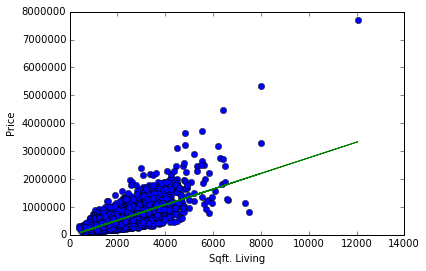

In [18]:
plt.plot(test.select('sqft_living').collect(),test.select('price').collect(),'o',
        test.select('sqft_living').collect(),singleFeatureModelPredictions.select('prediction').collect(),'-')
plt.xlabel('Sqft. Living')
plt.ylabel('Price')
plt.show()

## A more advanced model

We will now leverage on more features to build a more advanced model that hopefully will lead to better results.

We will take advange of the pipeline system to pre-process some of the features. In this example the *zipcode*, *yr_built* and *yr_renovated* are [categrical variables](https://en.wikipedia.org/wiki/Categorical_variable) and we are pre-processing it via One Hot Encoding algorithm.

In [32]:
features_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above',\
                    'sqft_basement', 'yr_builtVector', 'yr_renovatedVector', 'zipcodeVector', 'lat', 'long',\
                    'sqft_living15', 'sqft_lot15']


zipcodeStringIndexer = StringIndexer(inputCol="zipcode", outputCol="zipIndex", handleInvalid='skip')
zipcodeOneHotEncoder = OneHotEncoder(dropLast=False, inputCol="zipIndex", outputCol="zipcodeVector")
yearBuiltStringIndexer = StringIndexer(inputCol="yr_built", outputCol="yr_builtIndex", handleInvalid='skip')
yearBuiltOneHotEncoder = OneHotEncoder(dropLast=False, inputCol="yr_builtIndex", outputCol="yr_builtVector")
yearRenovatedStringIndexer = StringIndexer(inputCol="yr_renovated", outputCol="yr_renovatedIndex", handleInvalid='skip')
yearRenovatedOneHotEncoder = OneHotEncoder(dropLast=False, inputCol="yr_renovatedIndex", outputCol="yr_renovatedVector")

vectorAssembler = VectorAssembler(inputCols=features_columns, outputCol='features')

linearRegression = GeneralizedLinearRegression(family="gaussian", link="log", maxIter=100, labelCol='price')

advancedPipeline = Pipeline(stages=[zipcodeStringIndexer, zipcodeOneHotEncoder,\
                                    yearBuiltStringIndexer, yearBuiltOneHotEncoder,\
                                    yearRenovatedStringIndexer, yearRenovatedOneHotEncoder,\
                                    vectorAssembler, linearRegression])

paramGrid = ParamGridBuilder()\
    .addGrid(linearRegression.regParam, [1.0, 0.1, 0.01])\
    .build()

crossValidator = CrossValidator(estimator=advancedPipeline,
                                estimatorParamMaps=paramGrid,
                                evaluator=regressionEvaluator,
                                numFolds=10)

advancedFeatureModel = crossValidator.fit(train)


In [33]:
advancedFeatureModelPredictions = advancedFeatureModel.transform(test)

In [34]:
advancedFeatureModelRMSE = regressionEvaluator.evaluate(advancedFeatureModelPredictions)

In [35]:
print "Advanced Features Model RMSE: %s" % advancedFeatureModelRMSE

Advanced Features Model RMSE: 154857.94152


#### The AdvancedFeatureModel has an RMSE of about 151.883$

## Let's use our model to predict some house prices

<img src="http://blue.kingcounty.com/Assessor/eRealProperty/MediaHandler.aspx?Media=2916871" alt="Parcel 5309101200" style="align: center;"/>



In [42]:
kc_house_data.filter('id=5309101200')\
             .select('yr_built', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',\
                     'view', 'condition', 'grade', 'zipcode')\
             .show()

+--------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+-------+
|yr_built|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|zipcode|
+--------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+-------+
|    1929|620000.0|       4|     2.25|       2400|    5350|   1.5|         0|   0|        4|    7|  98117|
+--------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+-------+



In [25]:
advancedFeatureModel.transform(kc_house_data.filter('id=5309101200')).select('price', 'prediction').collect()

[Row(price=620000.0, prediction=543237.2120918719)]

## Lets try with another house in the dataset:

<img src="http://blue.kingcounty.com/Assessor/eRealProperty/MediaHandler.aspx?Media=3245161" alt="Parcel 7979900210" style="align: center;"/>



In [41]:
kc_house_data.filter('id=7979900210')\
             .select('yr_built', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',\
                     'view', 'condition', 'grade', 'zipcode')\
             .show()

+--------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+-------+
|yr_built|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|zipcode|
+--------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+-------+
|    1954|418900.0|       3|      1.5|       1470|   11112|   1.0|         0|   0|        3|    7|  98155|
+--------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+-------+



In [43]:
advancedFeatureModel.transform(kc_house_data.filter('id=7979900210')).select('price', 'prediction').collect()

[Row(price=418900.0, prediction=418927.87643787457)]

### Last but not least let's try with an house out of the dataset
Can you recognize it?


<img src="https://upload.wikimedia.org/wikipedia/commons/d/d9/Bill_gates%27_house.jpg" alt="Bill Gates" style="width: 100%;"/>


In [26]:
bill_gates_json = '{"id":0, "date":"19980423T000000","price":0.00,"bedrooms":8,"bathrooms":25,"sqft_living":50000,\
"sqft_lot":225000,"floors":4,"zipcode":"98039","condition":10,"grade":10,"waterfront":1,"view":4,"sqft_above":37500,\
"sqft_basement":12500,"yr_built":1994,"yr_renovated":2010,"lat":47.627606,"long":-122.242054,"sqft_living15":5000,\
"sqft_lot15":40000}'

Let's import the house data and adjust it to our dataset schema.

In [27]:
bill_gates = sqlContext.read.json(sc.parallelize([bill_gates_json]))

for field in kc_house_schema.fields:
    bill_gates = bill_gates.withColumn(field.name, bill_gates[field.name].cast(field.dataType).alias(field.name))

In [29]:
advancedFeatureModel.transform(bill_gates).select('prediction').show()

+--------------------+
|          prediction|
+--------------------+
|2.1420889193652208E9|
+--------------------+

